# Changes in chemfp 4.0

*Andrew Dalke - 1 October 2021*

The main new features are:
  - new "chemfp" command, with subcommands
  - diversity selection using MaxMin or sphere exclusion
  - high-level Python API
  - pandas integration
  - progress bars

## `chemfp` command

I've added new command-line components. Rather than have new top-level commands in the shell's path, I've created a new `chemfp` command-line program which supports subcommands.

The existing tools, like `simsearch` are still available on the the command-line. They are also available as subcommands, like:

```
chemfp simsearch --query 'c1ccccc1O' chembl_28.fpb
``` 

## Diversity selection

Chemfp now includes MaxMin and sphere exclusion methods to pick diverse fingerprints. These are available on the command-line through `chemfp maxmin` and `chemfp spherex`, respectively. For all my examples I'll use pre-generated RDKit Morgan fingerprints for a few datasets.

  - ChEMBL with 2M fingerprints
  - MolPort with 8M fingerprints
  - Asinex Gold and Platinum with 261k fingerprints

### MaxMin

The MaxMin algorithm is from Ashton, M., Barnard, J., Casset, F., Charlton, M., Downs, G., Gorse, D., Holliday, J., Lahana, R. and Willett, P. (2002), *Identification of Diverse Database Subsets using Property-Based and Fragment-Based Molecular Descriptions*. Quant. Struct.-Act. Relat., 21: 598-604 https://doi.org/10.1002/qsar.200290002 and optimized based on experience developing chemfp.

I'll use MaxMin to find the 50 most diverse fingerprints in 8M fingerprings from MolPort:

```
% chemfp maxmin "molport/All Stock Compounds/all_stock_compounds.fpb" --num-picks 50 --times
i	id	score
*	MolPort-046-758-640
0	MolPort-023-282-287	0.0000000
1	MolPort-029-996-256	0.0000000
2	MolPort-006-106-596	0.0000000
3	MolPort-006-123-276	0.0000000
   .. omitting many fingerprints with a score of 0.0 ..
34	MolPort-003-925-243	0.0000000
35	MolPort-047-715-358	0.0000000
36	MolPort-042-675-701	0.0000000
37	MolPort-021-070-534	0.0131579
38	MolPort-003-926-898	0.0144928
39	MolPort-006-129-578	0.0156250
40	MolPort-001-781-829	0.0158730
41	MolPort-047-853-169	0.0161290
42	MolPort-028-749-102	0.0163934
43	MolPort-046-683-501	0.0227273
44	MolPort-002-136-184	0.0285714
45	MolPort-003-931-393	0.0289855
46	MolPort-009-753-086	0.0315789
47	MolPort-039-141-565	0.0333333
48	MolPort-004-418-271	0.0348837
49	MolPort-047-458-501	0.0357143
T_init: 1.50 T_pick: 0.09 #picks: 50 picks/s: 571.71 T_total: 1.60
```

The `*` line in the output is because the MaxMin algorithm when used like this requires at least one initial pick, which in this case was chosen at random.

What you don't see from this document is the output is generated for each pick. If you don't specify `--num-picks` then it will keep printing output until all 8 million fingerprints have been selected. Or, you can use `--threshold` to have it stop once the scores have exceeded that threshold.

### MaxMin with reference fingerprints

What if you want to pick diverse MolPort fingerprints which are also diverse from your in-house collection?

I'll use ChEMBL as my reference data set of "compounds I have", to find "compounds I want" from the set of candidates.

<div class="alert alert-block alert-warning">
<b>Warning:</b> chemfp currently uses 'library' to refer to the reference data set. From user feedback, I believe 'reference' is a better term. This will likely change by chemfp 4.0 final release.
</div>


```
% chemfp maxmin "molport/All Stock Compounds/all_stock_compounds.fpb" --library chembl_.fpb --num-picks 20 --times
i	id	score
0	MolPort-035-944-309	0.0666667
1	MolPort-003-925-243	0.0769231
2	MolPort-046-418-717	0.0967742
3	MolPort-047-715-359	0.1111111
4	MolPort-003-931-393	0.1111111
5	MolPort-047-786-645	0.1111111
6	MolPort-047-785-953	0.1153846
7	MolPort-003-930-273	0.1176471
8	MolPort-028-746-255	0.1176471
9	MolPort-001-783-134	0.1250000
10	MolPort-003-930-167	0.1250000
11	MolPort-001-776-119	0.1250000
12	MolPort-047-715-196	0.1250000
13	MolPort-003-933-141	0.1304348
14	MolPort-047-919-115	0.1304348
15	MolPort-039-141-565	0.1346154
16	MolPort-044-181-316	0.1379310
17	MolPort-003-931-784	0.1428571
18	MolPort-003-930-617	0.1428571
19	MolPort-047-786-576	0.1428571
T_init: 1.56 T_pick: 7.03 #picks: 20 picks/s: 2.85 T_total: 8.62
```

### Sphere Exclusion

There are many variations of the sphere exclusion algorithm. The general approach is to pick a fingerprint, remove it and all fingerprints within a given theshold, and repeat the process until done.

The variations deal with how the fingerprints are picked. Chemfp by default uses a non-random approach - it selects the first available fingerprint. Since chemfp stores the fingerprints in popcount order, from smallest to largest, this means the least complex fingerprints are likely to be picked first.

It also doesn't seem to be that useful, because a lot of the small fingerprints are close to each other:

```
% chemfp spherex "molport/All Stock Compounds/all_stock_compounds.fpb" --threshold 0.2 --num-picks 10 --times
i	id	count
0	MolPort-016-950-362	94289
1	MolPort-001-756-353	6
2	MolPort-001-781-607	6
3	MolPort-001-783-134	1
4	MolPort-001-783-702	17
5	MolPort-001-786-695	16
6	MolPort-001-790-558	24
7	MolPort-003-925-087	6
8	MolPort-003-925-243	3
9	MolPort-003-925-458	3
T_init: 0.03 T_pick: 1.21 #picks: 10 picks/s: 8.25 T_total: 1.24
```

The `count` is the number of neighboring fingerprints (including the pick itself) found in the sphere.

If you want to pick the next fingerprint at random, then specify a seed for the random number generator, or use "auto" to let Python pick the seed:

```
% chemfp spherex "molport/All Stock Compounds/all_stock_compounds.fpb" --threshold 0.2 --num-picks 10 --seed auto --times
i	id	count
0	MolPort-002-674-440	55819
1	MolPort-000-757-411	88122
2	MolPort-006-381-481	84052
3	MolPort-028-801-115	141855
4	MolPort-046-451-420	58271
5	MolPort-006-505-423	890678
6	MolPort-019-797-062	549242
7	MolPort-008-266-128	72694
8	MolPort-023-157-567	420311
9	MolPort-019-713-257	151720
T_init: 0.03 T_pick: 3.54 #picks: 10 picks/s: 2.82 T_total: 3.58
```

<div class="alert alert-block alert-warning">
<b>NOTE:</b> I don't have much experience with sphere picking and would like feedback on good defaults. I suspect that the final 4.0 version will default to a randomly selected seed, with an option to choose selection based on popcount.
</div>

### DIrected Sphere Exclusion ("DISE")

The term "directed sphere exclusion" comes from Gobbi, A., & Lee, M. L. (2003). *DISE: directed sphere
exclusion*. Journal of Chemical Information and Computer Sciences, 43(1), 317-323. https://doi.org/10.1021/ci025554v .

Chemfp's default is to pick the next fingerprint based on smallest popcount. This is a sort of "directed" rather than random choice.

The DISE algorithm picks the next fingerprint based on its similarity to a set of three reference compounds. It chooses the fingerprint which is most similar to Sildenafil Citrate. Any ties are broken by their similarity to Isradipine. Any futher ties are broken by their similarity to Benazepril Hydrochloride. Any further times are broken by popcount/index order, though if a seed is specified then a fingerprint is chosen at random.

The reference fingerprints are computed as needed, based on the fingerprint type information in the candidates fingerprint file. In this case, chemfp determines that the MolPort data set uses Morgan fingerprints, then uses the RDKit to convert the reference SMILES strings into fingerprints, which it then uses to rank the fingerprints before doing the directed search.

```
% chemfp spherex "molport/All Stock Compounds/all_stock_compounds.fpb" --threshold 0.2 --num-picks 10 --dise --times
i	id	count
0	MolPort-003-850-246	143210
1	MolPort-042-676-216	120438
2	MolPort-000-762-565	248741
3	MolPort-044-563-819	176324
4	MolPort-047-604-219	34293
5	MolPort-007-587-293	345155
6	MolPort-003-053-890	500779
7	MolPort-002-320-440	98257
8	MolPort-047-686-497	117971
9	MolPort-046-683-715	27055
T_init: 5.12 T_pick: 10.02 #picks: 10 picks/s: 1.00 T_total: 31.41
```

I ran this again using `--seed auto` but the results were identical, suggesting either there were no further ties to resolve, or there's a bug in the code. `:)`

## High-level Python API, with pandas integration

The chemfp API is complete, but too low-level for exploratory use. I found that people even in the Jupyter notebook, who have direct access to chemfp's Python API, find it easier to work with the command-line tools and handle file conversion. For example, Pat Walters recently wrote an [essay on using pandas to read the output from chemfp's simsearch](https://github.com/PatWalters/blog_posts/blob/main/chemfp_simsearch.ipynb). The main goal was to show the flexbility of pandas' input reader, but it can also be seen as a limitation in the Python API.

Here I'll repeat the chemfp parts of Pat's essay, using the new high-level API.

### `chemfp.rdkit2fps` and similar functions

The first step is to download a data file:

In [1]:
!curl -O https://raw.githubusercontent.com/PatWalters/datafiles/main/chembl_drugs.smi


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84820  100 84820    0     0   231k      0 --:--:-- --:--:-- --:--:--  231k


and use RDKit to generate Morgan fingerprints for the SMILES strings.

In [2]:
import chemfp
chemfp.rdkit2fps("chembl_drugs.smi", "chembl_drugs.fpb")

chembl_drugs.smi:   0%|                                                                  | 0.00/84.8k [00:00<?…

ConversionInfo('processed structures from a file. #source_records=1203, #destination_records=1203 (total: 1.30 s)')

The high-level API uses progress bars in many places to provide some feedback on long calculations. It can be disabled with `progress=False`.

They also return an "Info" object of some describing what happened, along with timing information and other fields. 

There functions `chemfp.ob2fps`, `chemfp.oe2fps`, `chemfp.cdk2fps` are specialized for their respective toolkits. In particular, they support special aliases for the fingerprint type names, like "maccs" for the toolkit-specific MACCS implementation:

In [3]:
chemfp.ob2fps("chembl_drugs.smi", "ob_maccs.fps", type="maccs")

chembl_drugs.smi:   0%|                                                                  | 0.00/84.8k [00:00<?…

ConversionInfo('processed structures from a file. #source_records=1203, #destination_records=1203 (total: 2.09 s)')

In [4]:
chemfp.rdkit2fps("chembl_drugs.smi", "rdkit_maccs.fps", type="maccs")

chembl_drugs.smi:   0%|                                                                  | 0.00/84.8k [00:00<?…

ConversionInfo('processed structures from a file. #source_records=1203, #destination_records=1203 (total: 4.07 s)')

### `chemfp.simsearch` with a single query

The `chemfp.simsearch` command, for example returns a SimsearchInfo object with a `result` property:

In [5]:
imatinib_smiles = 'Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C'
info = chemfp.simsearch(query = imatinib_smiles, targets = "chembl_drugs.fpb", k=5)
info

SimsearchInfo('5-nearest Tanimoto search. #queries=1, #targets=1203 (search: 371.93 us total: 104.72 ms)'", result=SearchResult(#hits=5))

Many of the chemfp objects have been improved for use in a notebook environment, including adding useful "repr"s (the default text describing the object), and adding a `to_pandas()` method to convert the result to a pandas DataFrame.

In [6]:
info.result.to_pandas()

,target_id,score
0,CHEMBL1642,0.942029
1,CHEMBL1201740,0.505495
2,CHEMBL2105708,0.393939
3,CHEMBL1421,0.274510
4,CHEMBL1201733,0.255102


You can specify different columns if you wish.

In [7]:
info.result.to_pandas(columns=["ChEMBL id", "Tanimoto"])

,ChEMBL id,Tanimoto
0,CHEMBL1642,0.942029
1,CHEMBL1201740,0.505495
2,CHEMBL2105708,0.393939
3,CHEMBL1421,0.274510
4,CHEMBL1201733,0.255102


I'll follow Pat's lead and show the matching SMILES strings as well, using pandas to merge these results with the data from the SMILES file:

In [8]:
import pandas as pd
drug_df = pd.read_csv("chembl_drugs.smi",sep=" ",names=["SMILES","Name"])
nearest_df = info.result.to_pandas(columns=["Name", "Sim"])
nearest_df.merge(drug_df, on="Name")

,Name,Sim,SMILES
0,CHEMBL1642,0.942029,CS(=O)(=O)O.Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc...
1,CHEMBL1201740,0.505495,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...
2,CHEMBL2105708,0.393939,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
3,CHEMBL1421,0.274510,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...
4,CHEMBL1201733,0.255102,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...


### `chemfp.simsearch` with a k=5 NxN search

I'll now find the 5-nearest neighbors for each fingerprint in `chembl_drugs.fpb`.

In [9]:
info = chemfp.simsearch(targets="chembl_drugs.fpb", NxN=True, k=5)
info

queries:   0%|          | 0/1203 [00:00<?, ?fps/s]

SimsearchInfo('5-nearest Tanimoto NxN search. #fingerprints=1203 (search: 110.26 ms total: 163.03 ms)'", result=SearchResults(#queries=1203, #targets=1203))

The `SimsearchInfo.result` in this case contains a `SearchResults` object, which has been part of chemfp for a long time. The chemfp 4.0 release adds a `to_pandas()` method, which returns a data frame with three columns:

In [10]:
info.result.to_pandas()

,query_id,target_id,score
0,CHEMBL1201084,CHEMBL1201083,0.333333
1,CHEMBL1201084,CHEMBL1200574,0.333333
2,CHEMBL1201084,CHEMBL1353,0.111111
3,CHEMBL1201084,CHEMBL3989856,0.111111
4,CHEMBL1201084,CHEMBL2107525,0.100000
...,...,...,...
6010,CHEMBL3707372,CHEMBL2063090,0.496350
6011,CHEMBL3707372,CHEMBL3545363,0.496350
6012,CHEMBL3707372,CHEMBL3707183,0.194245
6013,CHEMBL3707372,CHEMBL2359966,0.194245


<AxesSubplot:xlabel='score', ylabel='Density'>

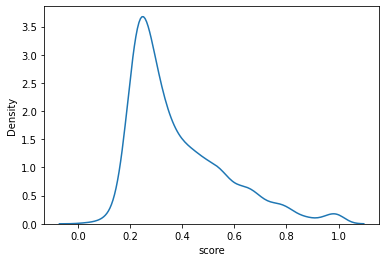

In [11]:
import seaborn as sns
sns.kdeplot(info.result.to_pandas()["score"])

### to_pandas() when a query has no matches.

I'll do another NxN search, this time with a threshold.

In [12]:
info = chemfp.simsearch(NxN=True, threshold=0.7, targets="chembl_drugs.fpb")
info

queries:   0%|          | 0/1203 [00:00<?, ?fps/s]

SimsearchInfo('Tanimoto threshold >= 0.7 NxN search. #fingerprints=1203 (search: 229.59 ms total: 240.22 ms)'", result=SearchResults(#queries=1203, #targets=1203))

Let's take a look at the results as a pandas DataFrame.

In [13]:
info.result.to_pandas()

,query_id,target_id,score
0,CHEMBL1201084,*,NaN
1,CHEMBL1200731,*,NaN
2,CHEMBL1201083,*,NaN
3,CHEMBL1141,*,NaN
4,CHEMBL1200706,*,NaN
...,...,...,...
1348,CHEMBL3545062,*,NaN
1349,CHEMBL3137333,*,NaN
1350,CHEMBL1908360,CHEMBL413,0.872727
1351,CHEMBL3137309,*,NaN


The NaN columns occur for queries which have no matches. Chemfp stores a list of hits for query. The `to_pandas()` flattens the list by using the query id for the first column and creating a new row for each hit (target id and score).

But what to do if there are not matches? I decided to insert a placeholder row, so each query id occurs at least once in the output data frame (even if there are no matches), and use the placeholder id `*` and "not a number" value for the score.

Pandas and other tools handle NaN values correctly, usually by ignoring them.

<AxesSubplot:xlabel='score', ylabel='Density'>

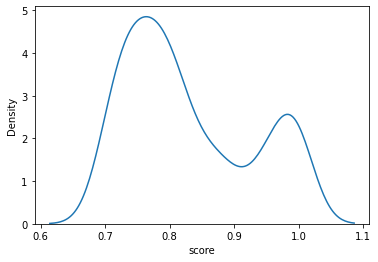

In [14]:
sns.kdeplot(info.result.to_pandas()["score"])

You can specify an alternative placeholder name and value with the `empty` parameter:

In [15]:
info.result.to_pandas(empty=(None, 0.0))

,query_id,target_id,score
0,CHEMBL1201084,None,0.000000
1,CHEMBL1200731,None,0.000000
2,CHEMBL1201083,None,0.000000
3,CHEMBL1141,None,0.000000
4,CHEMBL1200706,None,0.000000
...,...,...,...
1348,CHEMBL3545062,None,0.000000
1349,CHEMBL3137333,None,0.000000
1350,CHEMBL1908360,CHEMBL413,0.872727
1351,CHEMBL3137309,None,0.000000


Or pass `empty=None` to not include placeholder rows for queries with no hits.

In [16]:
info.result.to_pandas(empty=None)

,query_id,target_id,score
0,CHEMBL1200826,CHEMBL1200539,0.750000
1,CHEMBL1200539,CHEMBL1200826,0.750000
2,CHEMBL2021424,CHEMBL2105897,0.750000
3,CHEMBL2105897,CHEMBL2021424,0.750000
4,CHEMBL3989856,CHEMBL3989857,0.777778
...,...,...,...
439,CHEMBL2218877,CHEMBL532,0.710000
440,CHEMBL2218877,CHEMBL1200688,0.750000
441,CHEMBL2218877,CHEMBL1200510,0.726415
442,CHEMBL413,CHEMBL1908360,0.872727


## `chemfp.maxmin`

There are also high-level interface to the MaxMin and sphere exclusion algorithms, as `chemfp.maxmin` and `chemfp.spherex`.

In [17]:
info = chemfp.maxmin(
    candidates = "molport/All Stock Compounds/all_stock_compounds.fpb",
    library = "chembl_28.fpb",
    num_picks = 10)
info

picks:   0%|                                                                                        | 0/10 [00…

MaxMinInfo('picked 10 fps. similarity <= 1.0, #candidates=8074078, #library=2066376 (pick: 7.58 s, total: 11.10 s)', picker=MaxMinPicker(#candidates=8074068, #picks=10), result=PicksAndScores(#picks=10))

The MaxMinInfo object's `result` by default contains the picks and corresponding maximum similarity score.

In [18]:
info.result.to_pandas()

,pick_id,score
0,MolPort-035-944-309,0.066667
1,MolPort-003-925-243,0.076923
2,MolPort-046-418-717,0.096774
3,MolPort-047-715-359,0.111111
4,MolPort-003-931-393,0.111111
5,MolPort-047-786-645,0.111111
6,MolPort-047-785-953,0.115385
7,MolPort-003-930-273,0.117647
8,MolPort-028-746-255,0.117647
9,MolPort-001-783-134,0.125000


## High-level access to fingerprint types

There is a new way to get access to a fingerprint type for a given toolkit.

Previously you needed to construct it manually, as with:

In [19]:
chemfp.get_fingerprint_type("RDKit-Morgan")

RDKitMorganFingerprintType_v1(<RDKit-Morgan/1 radius=2 fpSize=2048 useFeatures=0 useChirality=0 useBondTypes=1>)

(See how the fingerprint type's `repr()` now includes the fingerprint type string instead of Python's default? This is part of the changes to make chemfp more useful in Jupyter or other interactive environment.)

With chemfp 4 you can instead refer to it via `chemfp.rdkit.morgan`:

In [20]:
chemfp.rdkit.morgan

RDKitMorganFingerprintType_v1(<RDKit-Morgan/1 radius=2 fpSize=2048 useFeatures=0 useChirality=0 useBondTypes=1>)

(Under the covers this creates a new fingerprint instance each time.)

You can also use the type to make a new type with modified parameters, like:

In [21]:
chemfp.rdkit.morgan(fpSize=1024, useFeatures=1)

RDKitMorganFingerprintType_v1(<RDKit-Morgan/1 radius=2 fpSize=1024 useFeatures=1 useChirality=0 useBondTypes=1>)

These values can be passed into the other high-level APIs:

In [22]:
chemfp.rdkit2fps("chembl_drugs.smi", "fcfp.fps", type=chemfp.rdkit.morgan(fpSize=1024, useFeatures=1))

chembl_drugs.smi:   0%|                                                                  | 0.00/84.8k [00:00<?…

ConversionInfo('processed structures from a file. #source_records=1203, #destination_records=1203 (total: 2.25 s)')

In [23]:
!head fcfp.fps

#FPS1
#num_bits=1024
#type=RDKit-Morgan/1 radius=2 fpSize=1024 useFeatures=1 useChirality=0 useBondTypes=1
#software=RDKit/2021.03.1 chemfp/4.0b1
#source=chembl_drugs.smi
#date=2021-10-01T11:36:25
5700080000000100000000000000000008000000000000000000000000002000000000000000000b00000000000000000000000000100000000000080000000000001000000000000140400000000080000000000040000000000010000000000000800000000001000000000000000000000000010000000000000002008201	CHEMBL700
0700000000000020000000000000008800000000000000000000200000000000000000000100000000000000000000000000000001000008000000000000080000000000000000000000000000000000100000000000080000020000800000000008000100000000000000000000000000000000000000000000004000000001	CHEMBL1200982
0d01020000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000	CHEMBL12

## Progress bars

As you've likely noticed, chemfp supports progress bars in the Jupyter environment. In a text-based environment, like the standard Python shell, chemfp will use text-based progress bars. Both are thanks to [tqdm](https://tqdm.github.io/). Chemfp includes a limited copy of tqdm with its distribution, which it will use if tqdm is not installed in your Python environment.

Most of the command-line tools have been updated to use the progress bar, as in this example:

```
% rdkit2fps --morgan chembl_drugs.smi -o test.fps
chembl_drugs.smi: 100%|██████████████████████████████████████████████████████████| 84.8k/84.8k [00:00<00:00, 126kbytes/s]
```

<div class="alert alert-block alert-warning">
<b>NOTE:</b> I plan to change `rdkit2fps` so it defaults to `--morgan` fingerprints instead of RDKit's Daylight-like fingerprints.
</div>
